In [27]:
import numpy as np

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import DensityMatrix, random_clifford, Statevector, Operator, random_density_matrix
from qiskit_aer import AerSimulator
from qiskit.circuit.library import IGate, XGate, YGate, ZGate

from tqdm import tqdm
from scipy.linalg import eigh, sqrtm

from qiskit.visualization import plot_state_city
import matplotlib.cm as cm
import matplotlib.pyplot as plt

## Classical shadow (n - Cliffrod gate) base code

In [2]:
class Classical_shadow:
    def __init__(self, init_density, sample_N):
        self.init_density = init_density
        self.num_qubits = init_density.num_qubits 
        self.circuit = QuantumCircuit(self.num_qubits)
        self.operator_lists = None
        self.sample_N = sample_N
        self.group_K = None
        self.unitary_N = None
        self.random_method = None
        self.random_unitary = None
        self.individual_unitary = None # For random pauli
        self.rho_list=[]
        self.group_rho_list=[]
        self.trace_data=None
        
    def get_random_unitary(self, method): # method = "pauli", "n-clifford", "user-defined"
        # return : (operator, qubits : list)
        if method == "n-clifford":
            applied_qubit = np.arange(self.num_qubits)
            random_unitary = random_clifford(self.num_qubits)
            return (random_unitary, list(applied_qubit))

    def add_random_unitary(self, method, unitary_N):
        self.random_method = method
        self.unitary_N = unitary_N
        for i in range(unitary_N):
            temp = self.get_random_unitary(method)
            self.circuit.append(temp[0], temp[1])
                
        # Calculate circuit unitary matrix
        self.random_unitary = Operator(self.circuit)
        init = QuantumCircuit(self.num_qubits)
        init.set_density_matrix(self.init_density)
        self.circuit = init.compose(self.circuit, list(range(self.num_qubits)))
        
    def reconstruct_density(self, method, unitary_N):
        self.add_random_unitary(method, unitary_N)
        simulator = AerSimulator()
        self.circuit.measure_all()
        transpiled_qc = transpile(self.circuit, simulator)
        result = simulator.run(transpiled_qc, shots=1).result()

        if method == "n-clifford":
            basis = Statevector.from_label(list(result.get_counts().keys())[0]).data.reshape(1,-1)
            basis = basis * basis.T
            rho = (2**(self.num_qubits) + 1) * self.random_unitary.data.conj().T @ basis @ self.random_unitary.data - np.eye(2**self.num_qubits) 
            return rho

    def get_reconstruct_density(self, method, unitary_N, nearest=True):
        result = []
        temp = []
        for i in tqdm(range(self.sample_N)):
            self.initialize()
            temp.append(self.reconstruct_density(method, unitary_N))
            if nearest:
                result.append(nearest_density_matrix(sum(temp)/len(temp)))
            else:
                result.append(sum(temp)/len(temp))
        return result
    
    def prediction_multi(self, method, unitary_N, observable_list, K):
        self.trace_data = []
        
        self.group_K = K
        for i in tqdm(range(self.sample_N)):
            self.initialize()
            self.rho_list.append(self.reconstruct_density(method, unitary_N))

        group_n = self.sample_N // K
        temp=0.0
        for i in range(group_n):
            for j in range(K):
                temp=temp+self.rho_list[i*K+j]
            self.group_rho_list.append(temp/K)
            temp=0.0

        result=[]

        for ind, observable in enumerate(observable_list):
            temp=[]
            for i in self.group_rho_list:
                temp.append(np.trace(i @ observable))
            self.trace_data.append(np.array(temp, dtype=float))
            result.append(np.median(np.array(temp,dtype=float)))

        return result
    
    def prediction(self, method, unitary_N, observable, K):
        self.group_K = K
        for i in tqdm(range(self.sample_N)):
            self.initialize()
            self.rho_list.append(self.reconstruct_density(method, unitary_N))

        group_n = self.sample_N // K
        temp=0.0
        for i in range(group_n):
            for j in range(K):
                temp=temp+self.rho_list[i*K+j]
            self.group_rho_list.append(temp/K)
            temp=0.0

        temp=[]
        for i in self.group_rho_list:
            temp.append(np.trace(i @ observable))
        self.trace_data = np.array(temp, dtype=float)

        return np.median(np.array(temp,dtype=float))

    def initialize(self):
        self.circuit = QuantumCircuit(self.num_qubits)
        
    def draw_circuit(self):
        return self.circuit.draw()
        

In [3]:
def nearest_density_matrix(matrix):
    """
    Estimate the nearest physical density matrix to a given matrix.
    Ensures the matrix is Hermitian, positive semi-definite, and has trace one.
    """
    # Ensure the matrix is Hermitian
    matrix = (matrix + matrix.conj().T) / 2
    # Eigenvalue decomposition
    eigenvalues, eigenvectors = eigh(matrix)
    # Set negative eigenvalues to zero (project onto the space of positive semi-definite matrices)
    eigenvalues = np.clip(eigenvalues, a_min=0, a_max=None)
    # Reconstruct the matrix with the non-negative eigenvalues
    matrix_psd = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.conj().T
    # Normalize the matrix so that its trace equals one
    density_matrix = matrix_psd / np.trace(matrix_psd)

    return density_matrix
    
def calculate_fidelity(rho, psi): # rho : density matrix, psi : State vector
    return np.real(psi.data @ rho.data @ psi.data.T)

def calculate_trace_distance(rho1, rho2): # rho : density matrix
    return np.linalg.norm(rho1-rho2, ord=1)*0.5

def plot_QST_2d(rho):
    fig = plt.figure(figsize=(10, 5))
    # Create a grid layout with 3 columns, where the colorbar will occupy the last column
    gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.3)
    
    # Create the first subplot for the real part
    ax1 = fig.add_subplot(gs[0, 0])
    im1 = ax1.imshow(rho.data.real, vmax=0.7, vmin=-0.7, cmap=cm.winter)
    ax1.set_yticks(np.arange(0, 4, 1))
    ax1.set_title("Real")
    
    # Create the second subplot for the imaginary part
    ax2 = fig.add_subplot(gs[0, 1])
    im2 = ax2.imshow(rho.data.imag, vmax=0.7, vmin=-0.7, cmap=cm.winter)
    ax2.set_yticks(np.arange(0, 4, 1))
    ax2.set_title("Imag")
    
    # Add the colorbar to the third column
    cbar = fig.colorbar(im2, cax=fig.add_subplot(gs[0, 2]))
    cbar.set_ticks(np.linspace(-0.7, 0.7, 5))

    return plt.show()    

## Problem 2.
### 1) State : Bell State ($\ket{\psi} = (\ket{00}+\ket{11})/\sqrt{2}$)

In [40]:
# State defined
rho_bell = DensityMatrix(np.array([[0.5, 0, 0, 0.5],[0,0,0,0],[0,0,0,0],[0.5, 0, 0, 0.5]]))
shadow = Classical_shadow(rho_bell, 5000)

# reconstruct density by classical shadow 
density_raw = shadow.get_reconstruct_density("n-clifford", unitary_N=1, nearest=False)
density = shadow.get_reconstruct_density("n-clifford", unitary_N=1, nearest=True)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:21<00:00, 61.57it/s]


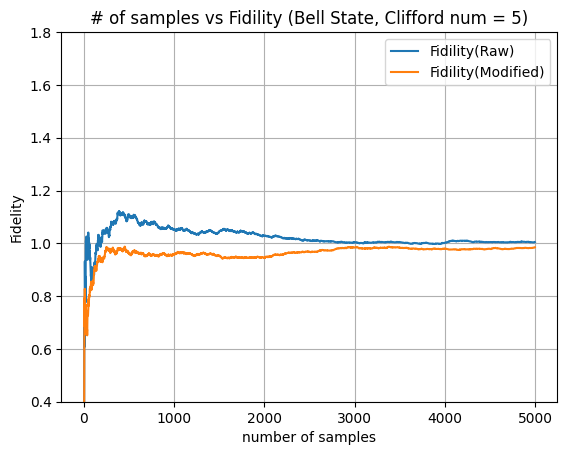

In [41]:
# Calculate fidility, trace_distance
fidility_raw = [calculate_fidelity(DensityMatrix(i), Statevector(1/np.sqrt(2)*np.array([1,0,0,1]))) for i in density_raw]
fidility = [calculate_fidelity(DensityMatrix(i), Statevector(1/np.sqrt(2)*np.array([1,0,0,1]))) for i in density]
trace_distance_raw = [calculate_trace_distance(i, rho_bell.data) for i in density_raw]
trace_distance = [calculate_trace_distance(i, rho_bell.data) for i in density]


plt.xlabel('number of samples', fontsize=10)
plt.ylabel('Fidelity', fontsize=10)
j = range(len(fidility_raw)) 
plt.plot(j, fidility_raw, label="Fidility(Raw)")
plt.plot(j, fidility, label="Fidility(Modified)")
plt.grid(True)
plt.ylim([0.40,1.8])
plt.title("# of samples vs Fidility (Bell State, Clifford num = 1)")
plt.legend(fontsize=10)

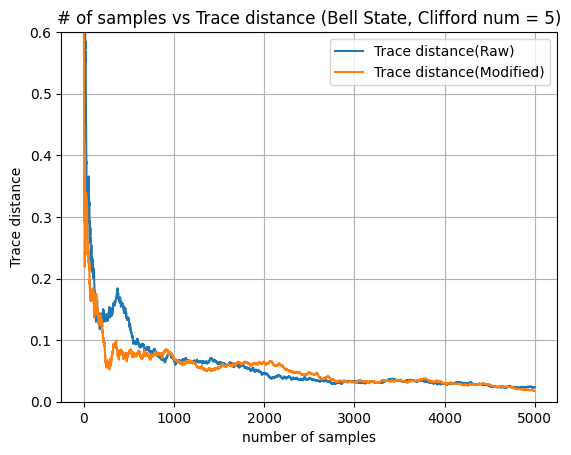

In [42]:
 
plt.xlabel('number of samples', fontsize=10)
plt.ylabel('Trace distance', fontsize=10)
j = range(len(fidility_raw)) 
plt.plot(j, trace_distance_raw, label="Trace distance(Raw)")
plt.plot(j, trace_distance, label="Trace distance(Modified)")
plt.grid(True)
plt.ylim([0.00,0.6])
plt.title("# of samples vs Trace distance (Bell State, Clifford num = 1)")
plt.legend(fontsize=10)
plt.show()

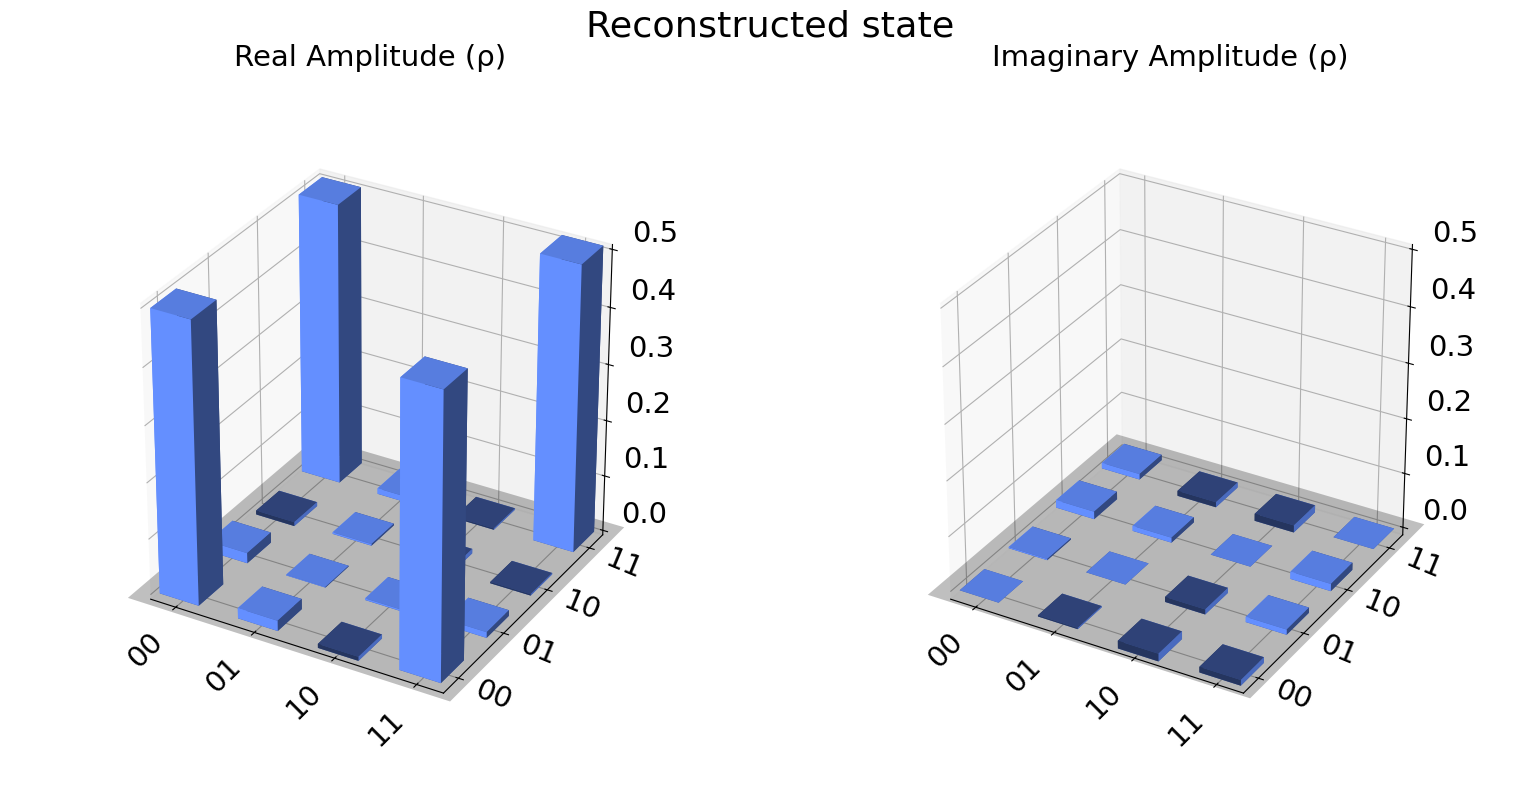

In [43]:
# Compare with orginal state(bell state) and reconstruced state
plot_state_city(density_raw[-1], title="Reconstructed state")

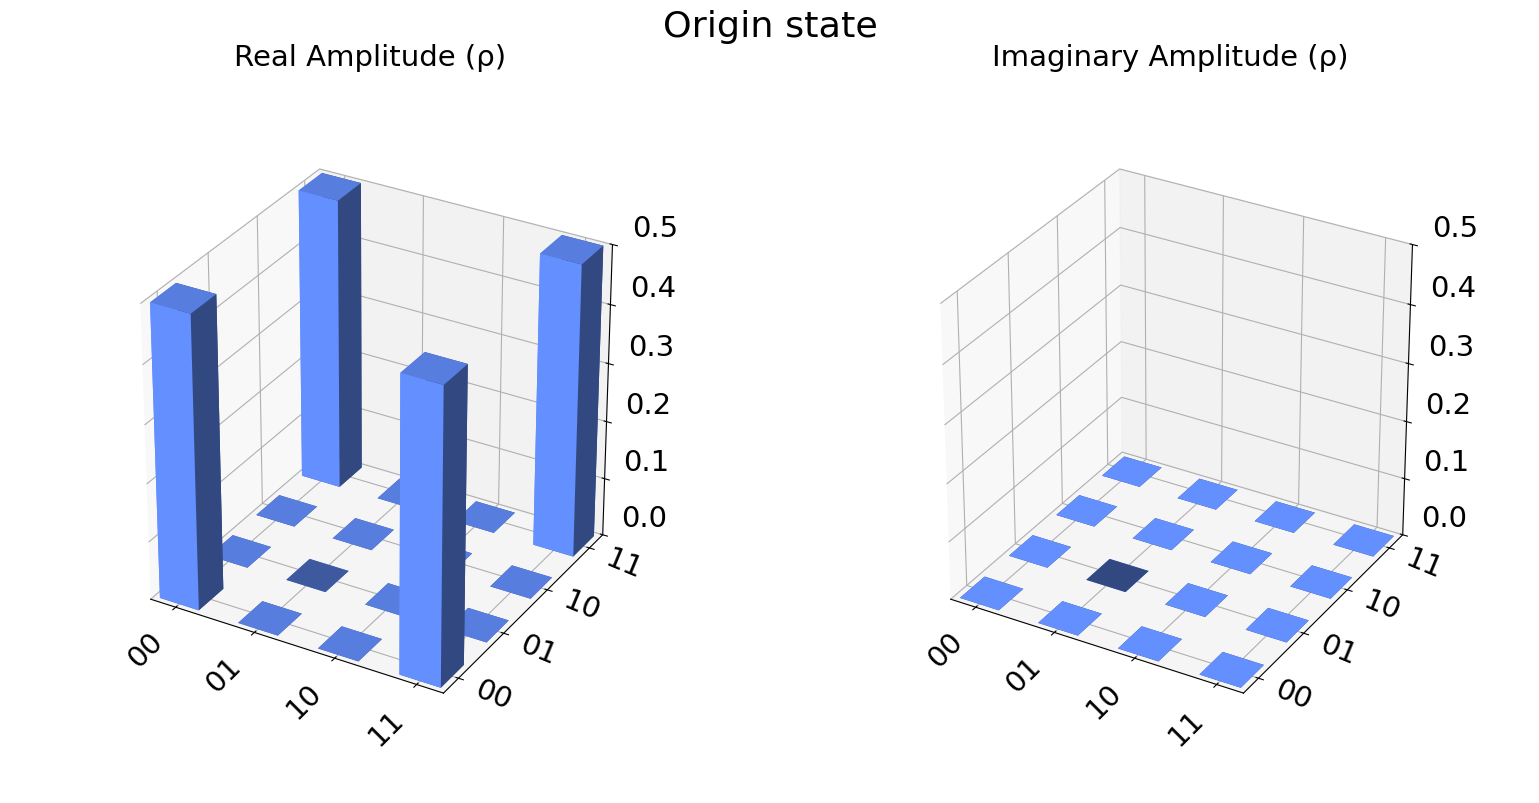

In [44]:
plot_state_city(rho_bell, title="Origin state")

### Trace distance in different number of Clifford gates (Bell State)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [06:42<00:00, 12.41it/s]


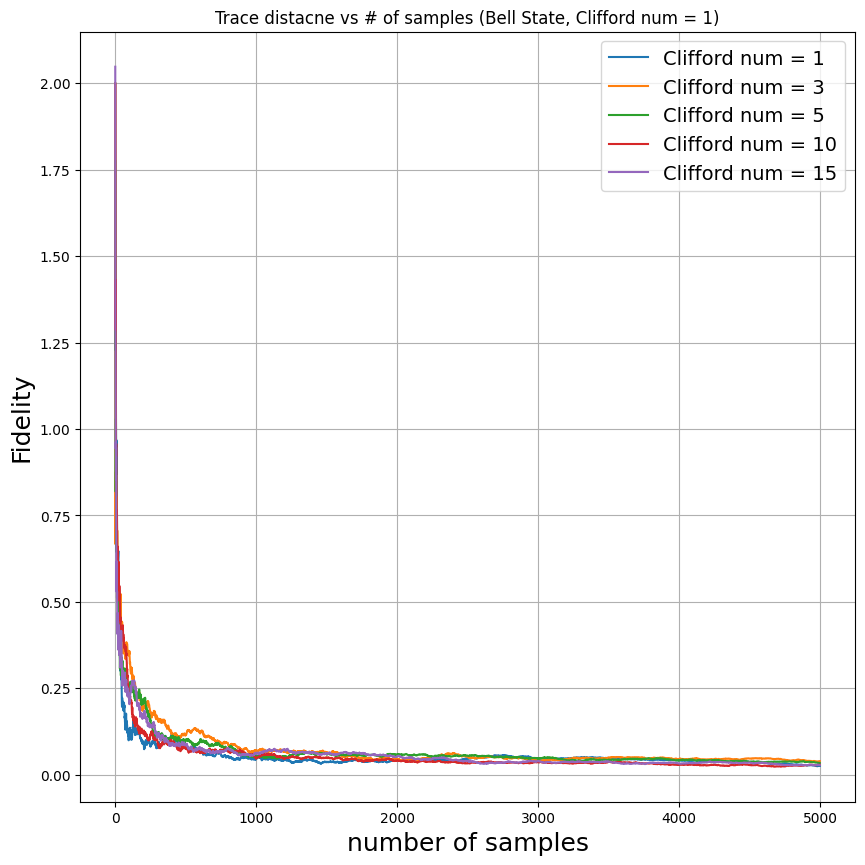

In [14]:
# Select the number of samples
shadow = Classical_shadow(rho_bell, 5000)

tracedistance = [[],[],[],[],[]] # # of clifford gate = 1,3,5,10,15
num_clifford = [1,3,5,10,15]

for k in range(5):
    density_raw = shadow.get_reconstruct_density("n-clifford", unitary_N=num_clifford[k], nearest=False)
    estimator_rho = []

    for i in density_raw:
        tracedistance[k].append(calculate_trace_distance(i,rho_bell.data))



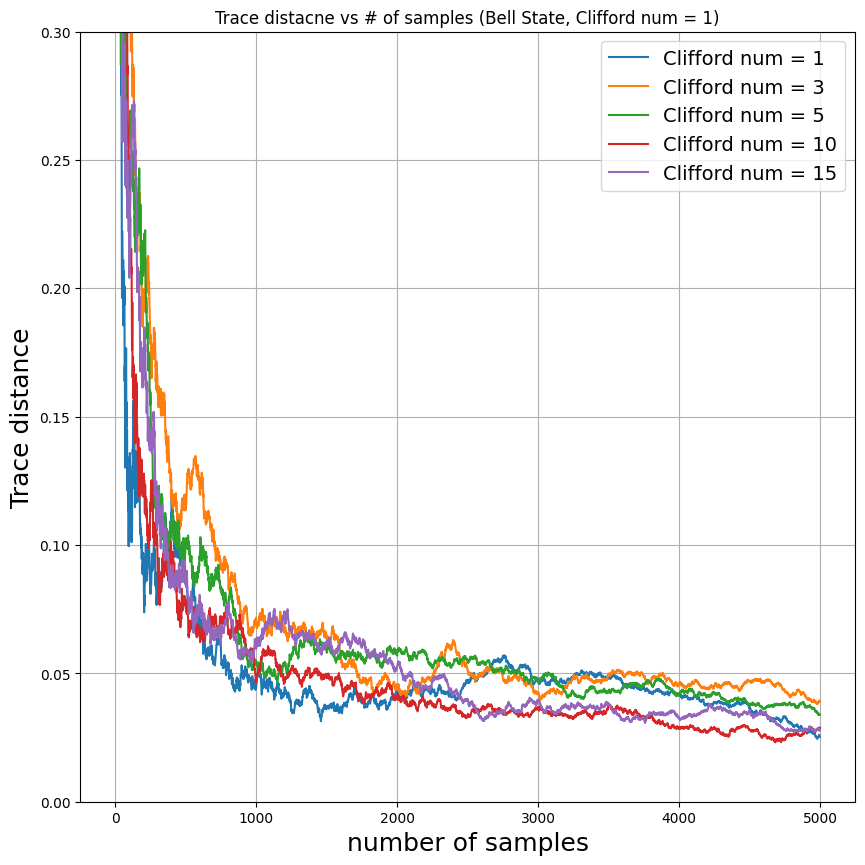

In [21]:
# Print out the result
fig,ax = plt.subplots(figsize=(10, 10))
 
plt.xlabel('number of samples', fontsize=18)
plt.ylabel('Trace distance', fontsize=18)
j = range(len(tracedistance[0])) 
plt.plot(j, tracedistance[0], label="Clifford num = 1")
plt.plot(j, tracedistance[1], label="Clifford num = 3")
plt.plot(j, tracedistance[2], label="Clifford num = 5")
plt.plot(j, tracedistance[3], label="Clifford num = 10")
plt.plot(j, tracedistance[4], label="Clifford num = 15")
"""open the grid"""
plt.grid(True)
plt.ylim([0,0.3])
plt.title("Trace distacne vs # of samples (Bell State, Clifford num = 1)")
plt.legend(fontsize=14)
plt.show()

### Observables error plot : $|<\sigma_{i}\sigma_{j}>_{exp}-<\sigma_{i}\sigma_{j}>_{exact}|$

In [22]:
paulis = [IGate().to_matrix(),XGate().to_matrix(),YGate().to_matrix(),ZGate().to_matrix()]
observable_list=[]
observable_list.append(np.kron(paulis[0],paulis[0]))
observable_list.append(np.kron(paulis[1],paulis[1]))
observable_list.append(np.kron(paulis[2],paulis[2]))
observable_list.append(np.kron(paulis[3],paulis[3]))
observable_list.append(np.kron(paulis[1],paulis[3]))
observable_list.append(np.kron(paulis[2],paulis[3]))

samples = list(np.arange(10,300,5))
error = []
exact = [1,1,-1,1,0,1]

for n in samples:
    shadow = Classical_shadow(rho_bell,n)
    result = shadow.prediction_multi("n-clifford",1,observable_list,5)
    error.append(np.array(result)-np.array(exact))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 61.00it/s]
C:\Users\pty13\AppData\Local\Temp\ipykernel_89296\10633134.py:84: ComplexWarning: Casting complex values to real discards the imaginary part
  self.trace_data.append(np.array(temp, dtype=float))
C:\Users\pty13\AppData\Local\Temp\ipykernel_89296\10633134.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  result.append(np.median(np.array(temp,dtype=float)))
100%|████████████████████████████████████████████████████████████████████████████████| 295/295 [00:04<00:00, 69.63it/s]


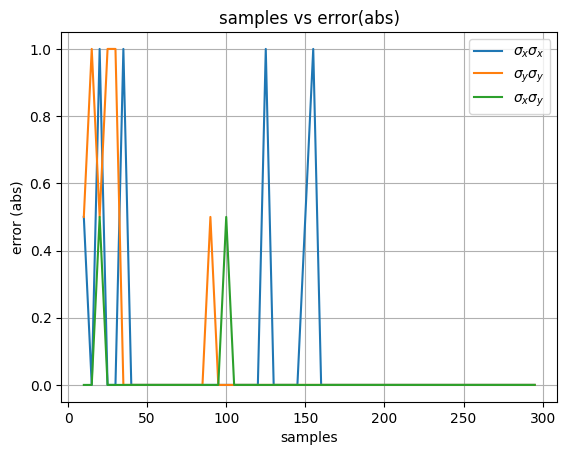

In [23]:
# Plot # of samples vs error (K=5)
error=np.abs(np.array(error))
plt.plot(samples,error[:,1], label = "$\sigma_{x}\sigma_{x}$")
plt.plot(samples,error[:,2], label = "$\sigma_{y}\sigma_{y}$")
plt.plot(samples,error[:,4], label = "$\sigma_{x}\sigma_{y}$")
plt.grid(True)
#plt.ylim([0.0,0.3])
plt.title("samples vs error(abs)")
plt.xlabel("samples")
plt.ylabel("error (abs)")
plt.legend(fontsize=10)
plt.show()

### 2) State : Multiparticle state 

In [24]:
def quantum_fidelity(rho, sigma):
    # Ensure rho and sigma are numpy arrays
    rho = np.array(rho)
    sigma = np.array(sigma)

    # Step 1: Compute the square root of rho
    sqrt_rho = sqrtm(rho)

    # Step 2: Compute the matrix product sqrt_rho * sigma * sqrt_rho
    product = sqrt_rho @ sigma @ sqrt_rho

    # Step 3: Compute the square root of the product matrix
    sqrt_product = sqrtm(product)

    # Step 4: Take the trace of the square root matrix
    trace_sqrt_product = np.trace(sqrt_product)

    # Step 5: Square the trace to obtain the fidelity
    fidelity = np.real(trace_sqrt_product)**2

    return fidelity

In [25]:
n_qubis = [2,3,4]
density_raw = []
density = []
rho_random_list = []

for n_qubit in n_qubis:
    rho_random = random_density_matrix((2,)*n_qubit) 
    rho_random_list.append(rho_random)
    shadow = Classical_shadow(rho_random, 500)
    
    # reconstruct density by classical shadow 
    density_raw.append(shadow.get_reconstruct_density("n-clifford", unitary_N=5, nearest=False))
    density.append(shadow.get_reconstruct_density("n-clifford", unitary_N=5, nearest=True))

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.54it/s]


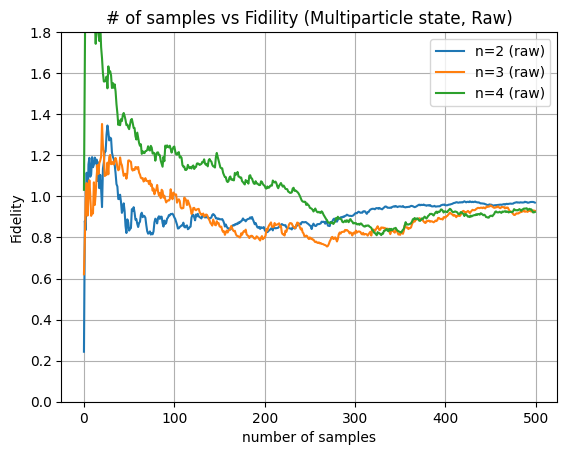

In [29]:
# Calculate fidility, trace_distance
fidility_raw=[None, None, None]
fidility=[None, None, None]
trace_distance_raw=[None, None, None]
trace_distacne=[None, None, None]

for k in range(3):
    trace_distance_raw[k] = [calculate_trace_distance(i,rho_random_list[k].data) for i in density_raw[k]]
    trace_distance[k] = [calculate_trace_distance(i,rho_random_list[k].data) for i in density[k]]
    
    fidility_raw[k] = [quantum_fidelity(i,rho_random_list[k].data) for i in density_raw[k]]
    fidility[k] = [quantum_fidelity(i,rho_random_list[k].data) for i in density[k]]

plt.xlabel('number of samples', fontsize=10)
plt.ylabel('Fidelity', fontsize=10)
plt.title("# of samples vs Fidility (Multiparticle state, Raw)")
j = range(len(fidility_raw[0]))
plt.plot(j, fidility_raw[0], label="n=2 (raw)")
plt.plot(j, fidility_raw[1], label="n=3 (raw)")
plt.plot(j, fidility_raw[2], label="n=4 (raw)")
#plt.plot(j, fidility[0], label="n=2")
#plt.plot(j, fidility[1], label="n=3")
#plt.plot(j, fidility[2], label="n=4")
plt.grid(True)
plt.ylim([0.0,1.8])
plt.legend(fontsize=10)

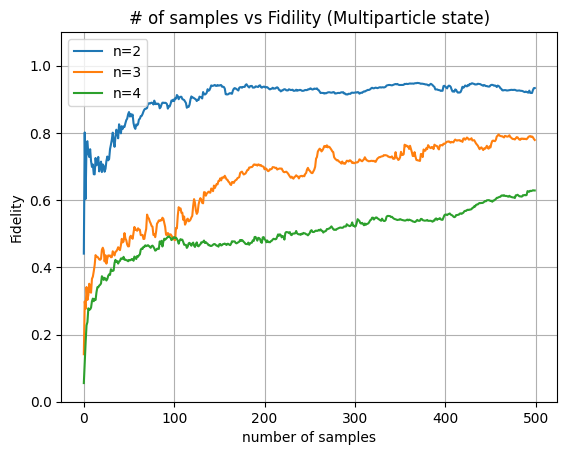

In [32]:
plt.xlabel('number of samples', fontsize=10)
plt.ylabel('Fidelity', fontsize=10)
plt.title("# of samples vs Fidility (Multiparticle state)")
j = range(len(fidility_raw[0]))
#plt.plot(j, fidility_raw[0], label="n=2 (raw)")
#plt.plot(j, fidility_raw[1], label="n=3 (raw)")
#plt.plot(j, fidility_raw[2], label="n=4 (raw)")
plt.plot(j, fidility[0], label="n=2")
plt.plot(j, fidility[1], label="n=3")
plt.plot(j, fidility[2], label="n=4")
plt.grid(True)
plt.ylim([0.0,1.1])
plt.legend(fontsize=10)

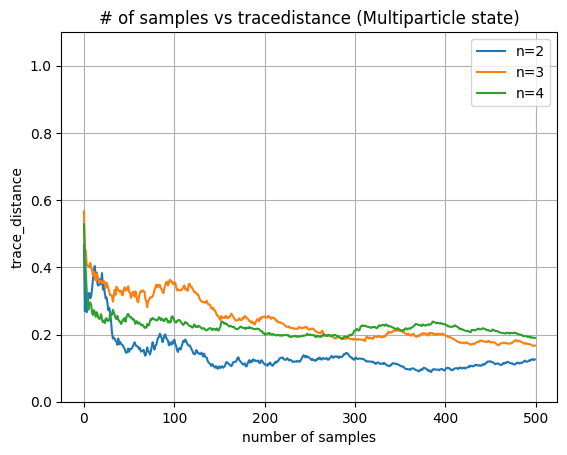

In [39]:
plt.xlabel('number of samples', fontsize=10)
plt.ylabel('trace_distance', fontsize=10)
plt.title("# of samples vs tracedistance (Multiparticle state)")
j = range(len(fidility_raw[0]))
#plt.plot(j, trace_distance_raw[0], label="n=2 (raw)")
#plt.plot(j, trace_distance_raw[1], label="n=3 (raw)")
#plt.plot(j, trace_distance_raw[2], label="n=4 (raw)")
plt.plot(j, trace_distance[0], label="n=2")
plt.plot(j, trace_distance[1], label="n=3")
plt.plot(j, trace_distance[2], label="n=4")
plt.grid(True)
plt.ylim([0.0,1.1])
plt.legend(fontsize=10)

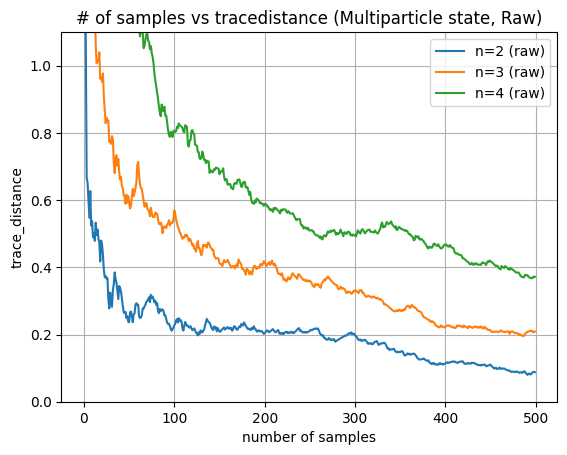

In [38]:
plt.xlabel('number of samples', fontsize=10)
plt.ylabel('trace_distance', fontsize=10)
plt.title("# of samples vs tracedistance (Multiparticle state, Raw)")
j = range(len(fidility_raw[0]))
plt.plot(j, trace_distance_raw[0], label="n=2 (raw)")
plt.plot(j, trace_distance_raw[1], label="n=3 (raw)")
plt.plot(j, trace_distance_raw[2], label="n=4 (raw)")
#plt.plot(j, trace_distance[0], label="n=2")
#plt.plot(j, trace_distance[1], label="n=3")
#plt.plot(j, trace_distance[2], label="n=4")
plt.grid(True)
plt.ylim([0.0,1.1])
plt.legend(fontsize=10)

### Classical Shadow error in Multiparticle State

In [54]:
n_qubis = [2,3,4]
density_raw = []
density = []
rho_random_list = [random_density_matrix((2,)*2),random_density_matrix((2,)*3),random_density_matrix((2,)*4)]

paulis = [IGate().to_matrix(),XGate().to_matrix(),YGate().to_matrix(),ZGate().to_matrix()]
observable_list=[]
observable_list.append(np.kron(paulis[1],paulis[1]))
observable_list.append(np.kron(np.kron(paulis[1],paulis[1]),paulis[1]))
observable_list.append(np.kron(np.kron(np.kron(paulis[1],paulis[1]),paulis[1]),paulis[1]))


exact = []
for i in range(3):
    exact.append(np.trace(rho_random_list[i].data@observable_list[i]).real)

samples = list(np.arange(50,700,20))
error = [[],[],[]]

for i in range(3):
    for n in samples:
        shadow = Classical_shadow(rho_random_list[i],n)
        result = shadow.prediction("n-clifford",5,observable_list[i],10)
        error[i].append(np.abs(np.array(result)-np.array(exact)))



100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 25.66it/s]
C:\Users\pty13\AppData\Local\Temp\ipykernel_89296\10633134.py:106: ComplexWarning: Casting complex values to real discards the imaginary part
  self.trace_data = np.array(temp, dtype=float)
C:\Users\pty13\AppData\Local\Temp\ipykernel_89296\10633134.py:108: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.median(np.array(temp,dtype=float))
100%|████████████████████████████████████████████████████████████████████████████████| 690/690 [00:59<00:00, 11.64it/s]


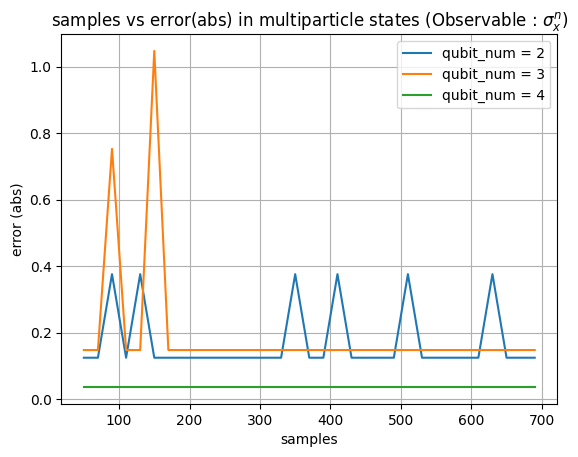

In [65]:
# Plot # of samples vs error (K=5)
error = np.array(error)
plt.plot(samples,error[0,:,0], label = "qubit_num = 2")
plt.plot(samples,error[1,:,1], label = "qubit_num = 3")
plt.plot(samples,error[2,:,2], label = "qubit_num = 4")
plt.grid(True)
#plt.ylim([0.0,0.3])
plt.title("samples vs error(abs) in multiparticle states (Observable : $\sigma_{x}^{n}$)")
plt.xlabel("samples")
plt.ylabel("error (abs)")
plt.legend(fontsize=10)
plt.show()

### 3) State : Werner state 

In [147]:
def density_werner(p):
    return DensityMatrix(p/2.*np.array([[0.,0,0,0],[0,1,-1,0],[0,-1,1,0],[0,0,0,0]])+(1.-p)/4.*np.eye(4))

Witness_observable = DensityMatrix(np.eye(4)/2 - 0.5*np.array([[0,0,0,0],[0,1,-1,0],[0,-1,1,0],[0,0,0,0]]))

p_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
density_list = []

for p in p_list:
    density_list.append(density_werner(p))

exact = []
result = []
fidelity = []
for i in range(len(p_list)):
    exact.append(np.trace(density_list[i].data@Witness_observable.data).real)

error = []
for i in range(len(p_list)):
    shadow = Classical_shadow(density_list[i], 1000)
    result.append(shadow.prediction("n-clifford",5,Witness_observable.data, 10))
    error.append(np.abs(result[i]-exact[i]))
    density = shadow.get_reconstruct_density("n-clifford", unitary_N=10, nearest=True)
    fidelity.append(quantum_fidelity(DensityMatrix(density[-1]), density_list[i]))
    print(result[-1], error[-1], fidelity[-1])

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 30.29it/s]
C:\Users\pty13\AppData\Local\Temp\ipykernel_89296\10633134.py:106: ComplexWarning: Casting complex values to real discards the imaginary part
  self.trace_data = np.array(temp, dtype=float)
C:\Users\pty13\AppData\Local\Temp\ipykernel_89296\10633134.py:108: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.median(np.array(temp,dtype=float))
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:58<00:00, 17.24it/s]


0.24999999999999667 3.3306690738754696e-15 0.9848183072922567


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:01<00:00, 16.23it/s]


0.12499999999999703 0.05000000000000296 0.9847328881216237


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.54it/s]


0.12499999999999656 0.024999999999996553 0.9863704736955373


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.50it/s]


-2.7755575615628914e-15 0.02500000000000277 0.9555681549566301


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.48it/s]


-2.824129818890242e-15 0.04999999999999719 0.9728917897153231


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.28it/s]


-0.12500000000000244 2.4424906541753444e-15 0.9815674937499941


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:58<00:00, 17.23it/s]


-0.250000000000002 0.050000000000002015 0.9711771597313388


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:55<00:00, 17.96it/s]


-0.2500000000000021 0.024999999999997857 0.8915092159505402


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.50it/s]


-0.37500000000000167 0.025000000000001632 0.9359154359946257


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.57it/s]


-0.5000000000000013 0.07500000000000129 0.9505409801283566


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:59<00:00, 16.76it/s]

-0.5000000000000013 1.3322676295501878e-15 0.9385269694358064


In [148]:
for i in range(len(p_list)):
    print(p_list[i],exact[i],result[i],error[i],fidelity[i])

0 0.25 0.24999999999999667 3.3306690738754696e-15 0.9848183072922567
0.1 0.175 0.12499999999999703 0.05000000000000296 0.9847328881216237
0.2 0.1 0.12499999999999656 0.024999999999996553 0.9863704736955373
0.3 0.024999999999999994 -2.7755575615628914e-15 0.02500000000000277 0.9555681549566301
0.4 -0.05000000000000002 -2.824129818890242e-15 0.04999999999999719 0.9728917897153231
0.5 -0.125 -0.12500000000000244 2.4424906541753444e-15 0.9815674937499941
0.6 -0.19999999999999998 -0.250000000000002 0.050000000000002015 0.9711771597313388
0.7 -0.27499999999999997 -0.2500000000000021 0.024999999999997857 0.8915092159505402
0.8 -0.35000000000000003 -0.37500000000000167 0.025000000000001632 0.9359154359946257
0.9 -0.42500000000000004 -0.5000000000000013 0.07500000000000129 0.9505409801283566
1.0 -0.5 -0.5000000000000013 1.3322676295501878e-15 0.9385269694358064


(0.0, 1.0)

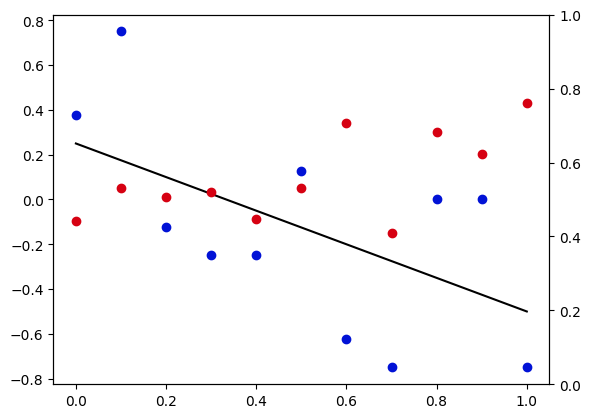

In [143]:
fig, ax1 = plt.subplots()
ax1.plot(p_list,exact,'k')
ax1.scatter(p_list,result,c="#0112d6")

ax2 = ax1.twinx()
ax2.scatter(p_list,fidelity,c="#d60112")
ax2.set_ylim([0,1])
